In [1]:
# importy bibliotek

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
pip install imblearn 

Note: you may need to restart the kernel to use updated packages.


In [3]:
from imblearn.over_sampling import SMOTEN

In [4]:
from sklearn.model_selection import train_test_split

### Wczytanie danych 

In [5]:
df = pd.read_csv('clean_dataset.csv')


In [6]:
df.columns

Index(['Unnamed: 0', 'basket_icon_click', 'basket_add_list',
       'basket_add_detail', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'sign_in', 'saw_checkout', 'saw_homepage',
       'ordered'],
      dtype='object')

### wyznaczenie zbioru objaśniającego (X) oraz objasnianej (y)

In [7]:
X = df.drop(labels = ['Unnamed: 0', 'ordered'], axis = 1)
y = df['ordered']

### modelowanie

In [8]:
# trenowanie 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)


In [9]:
#oversampling - SMOTE
smote = SMOTEN (random_state=123)


In [10]:
#trenowanie - SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [11]:
#sprawdzenie zbalansowania
y_train_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: ordered, dtype: float64

In [12]:
# funkcja do 'grid_combination'

def grid_combination(grid):
    total_params = 1 
    for par in grid:
        total_params  = total_params * len(grid[par])
    return total_params

In [13]:
# 'Przygotowanie siatki parametrów

param_grid = {"max_depth": [3,4, None],
              "max_features": list(range(2,8)),
              "n_estimators":[10,25, 50],
              "min_samples_leaf":[1,3,5,7],
              "criterion" : ['gini', 'entropy'], 
              }

print(param_grid)
print(f'Liczba wszystkich kombinacji: {grid_combination(param_grid)}')

{'max_depth': [3, 4, None], 'max_features': [2, 3, 4, 5, 6, 7], 'n_estimators': [10, 25, 50], 'min_samples_leaf': [1, 3, 5, 7], 'criterion': ['gini', 'entropy']}
Liczba wszystkich kombinacji: 432


In [14]:
#stworzenie klasyfikatora

rfc = RandomForestClassifier()

In [29]:
#Strojenie parametrów

random_search = RandomizedSearchCV(
    rfc,
    param_distributions=param_grid,
    cv=5,
    n_iter=5,
    verbose=5,
    scoring='accuracy',
    random_state=1   
)

In [30]:
#trenowanie oraz pomiar czasu
start = time.time()
random_search.fit(X_train_smote, y_train_smote)
end = time.time()
print("Czas treningu modelu RandomForest: ", end - start)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=25;, score=0.990 total time=   5.6s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=25;, score=0.991 total time=   4.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=25;, score=0.989 total time=   3.6s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=25;, score=0.990 total time=   4.2s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=3, n_estimators=25;, score=0.991 total time=   4.7s
[CV 1/5] END criterion=entropy, max_depth=None, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.992 total time=   9.8s
[CV 2/5] END criterion=entropy, max_depth=None, max_features=2, min_samples_leaf=3, n_estimators=50;, score=0.992 total time=  10.8s
[CV 3/5] END criterion=e

### Wyniki

In [31]:
# najlepsze parametry to:
random_search.best_params_

{'n_estimators': 10,
 'min_samples_leaf': 5,
 'max_features': 2,
 'max_depth': None,
 'criterion': 'entropy'}

In [32]:
# Score przy wyborze najlepszych parametrów to:
random_search.best_score_

0.9920209027289675

### tworzenie nowego classifier RF z najlepszymi parametrami

In [33]:
rfc_test = RandomForestClassifier(**random_search.best_params_)

In [34]:
# modelowanie
rfc_test.fit(X_test, y_test)

RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=5,
                       n_estimators=10)

In [35]:
# predykcja modelu na zbiorze testowym
y_pred = rfc_test.predict(X_test)

### Wyniki dla najlepszych parametrów

In [36]:
rfc_test.score(X_test, y_test)

0.9931138066420145

In [37]:
score = accuracy_score(y_test, y_pred)
print('Accuracy :',score)


Accuracy : 0.9931138066420145


In [38]:
class_report_RF = classification_report(y_test, y_pred, output_dict = True )
df_class_report_RF = pd.DataFrame(class_report_RF).transpose()
#df_class_report_RF.to_html('class_report_RF.html')
print(df_class_report_RF)


              precision    recall  f1-score        support
0              0.999548  0.993262  0.996395  109078.000000
1              0.865360  0.989734  0.923378    4773.000000
accuracy       0.993114  0.993114  0.993114       0.993114
macro avg      0.932454  0.991498  0.959886  113851.000000
weighted avg   0.993922  0.993114  0.993334  113851.000000


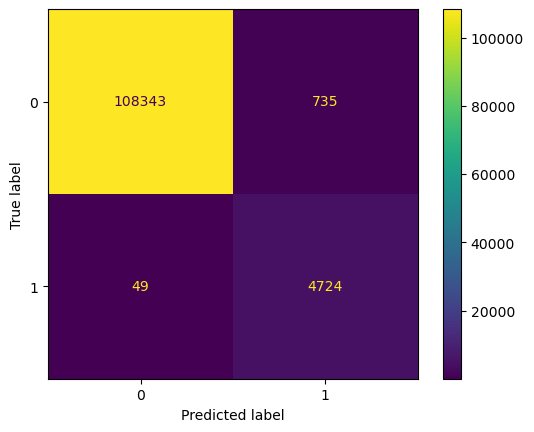

In [39]:
cm_RF = confusion_matrix(y_test, y_pred)
disp_cm_RF = ConfusionMatrixDisplay(cm_RF)
disp_cm_RF.plot();
plt.savefig('disp_cm_RF.png')